In [1]:
# Import necessary libraries
from fastbook import *
from fastai.vision.widgets import *
from fastai.imports import *

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', 'a181e59554404c0ea527d542640d7b8b')

In [3]:
# Download cavalier images
cav_types = ["blenheim","black and tan","ruby", "tricolor"]
path = Path("cavalier")
if not path.exists():
    path.mkdir()
    for o in cav_types: 
        dest = path/(o.replace(" ","_"))
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} cavalier king charles spaniel')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [240]:
# Get paths to images
fns = get_image_files(path)

In [241]:
# Verify images are valid
failed = verify_images(fns)

In [242]:
# Remove invalid images
failed.map(Path.unlink);

In [243]:
# Construct data block object
cavs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #Signify type of x and y 
    get_items=get_image_files, # Show how to retrive items
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # How to split valid and train
    get_y=parent_label, # How to get dependent var 
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # Transforms to apply to every image
    batch_tfms=aug_transforms()) # Augment each batch

In [244]:
# Show the actual path to the data to the datablock
dls = cavs.dataloaders(path)

In [245]:
# Fine tune the pretrained model
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.730835,0.171288,0.028037,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.462213,0.037092,0.009346,00:10
1,0.321712,0.013102,0.000000,00:10
2,0.236360,0.008747,0.000000,00:10
3,0.186200,0.009525,0.000000,00:08


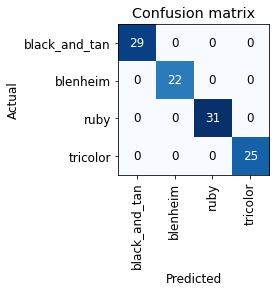

In [246]:
# View results 
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

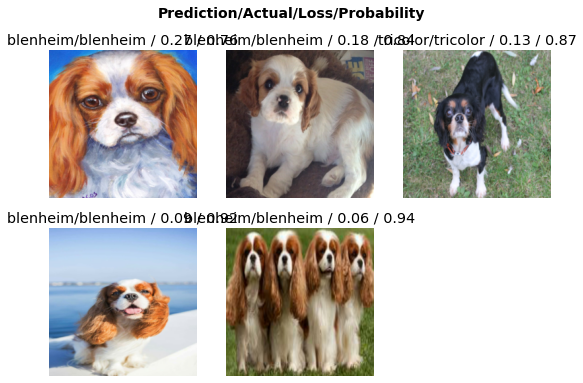

In [247]:
interp.plot_top_losses(5, nrows=2)

In [248]:
# Find bad/mislabeled data 
cleaner = ImageClassifierCleaner(learn)
cleaner

In [235]:
# Remove/move data
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): 
    src = os.path.join(os.getcwd(), str(cleaner.fns[idx]))
    dest = os.path.join(os.getcwd(), path/cat/str(cleaner.fns[idx].name))
    shutil.move(src, dest)

In [251]:
# Export architecture and weights
learn.export(fname="cav_export.pkl")